# Pytorch module to test scaling layer

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline
# ! pip install tensorflow==1.14.0

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import gzip
import pickle
import os
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from scale_layer import *
from torch.utils.tensorboard import SummaryWriter

In [3]:
def print_stats(model_p, sparsity=1e-4):
    params = torch.cat([param.view(-1) for param in list(model_p.parameters())])
    params_n = params.detach().numpy()
    N = params_n.size
    stats = {}
    print("Mean")
    stats['mean'] = np.mean(np.abs(params_n))
    print(stats['mean'])
    print("standard deviation")
    stats['std'] = np.sqrt(np.var(np.abs(params_n)))
    print(stats['std'])
    print("Sparsity")
    print(np.sum(np.abs(params_n)<sparsity)/N)

def get_model_error(model_t):
    tot_num = 0.0
    num_wrong = 0.0
    dataiter = iter(testloader)
    for images,labels in dataiter:
        outputs = model_t(images)
        for image, label, i in zip(images, labels, range(len(images))):
    #         imshow(image)
    #         print(model(image).detach().numpy())
    #         expected_class = classes[outputs[i].detach().numpy().argmax()]
            expected_class_i = int(outputs[i].detach().numpy().argmax())
    #         print("Predicted class: %s" % expected_class)
    #         print("expected: " + str(int(label)))
            tot_num+=1
            if int(label) != expected_class_i:
                num_wrong+=1
    error = num_wrong/tot_num
    print("test error: " + str(error))
    return error

In [4]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor()#,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
# print(torchvision.datasets.__dict__)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
writer = SummaryWriter(flush_secs=10)


In [12]:
ce_loss = nn.CrossEntropyLoss(reduction='sum')
model_new_t = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Conv2d(16, 32, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Flatten(),
    nn.Linear(5408, 1152),
    nn.ReLU(),
    nn.Linear(1152, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model_new = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Conv2d(16, 32, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Flatten(),
    nn.Linear(5408, 1152),
    ScaleLayer(writer=writer),
    nn.Linear(1152, 512),
    ScaleLayer(),
    nn.Linear(512, 128),
    ScaleLayer(),
    nn.Linear(128, 10)
)
## Define the loss function to be used
def criterion_p(op, y, model_p):
    params = list(model_p.parameters())
    return ce_loss(op, y) + (1/len(params))*(torch.norm(torch.cat([param.view(-1) for param in params]))) #+ torch.sum((1/len(params))*torch.exp(torch.abs(torch.cat([param.view(-1) for param in params]))))

def criterion_wo_norm(op, y, model_p):
    params = list(model_p.parameters())
    return ce_loss(op, y) #+ (1/len(params))*(torch.norm(torch.cat([param.view(-1) for param in params]))) #+ torch.sum((1/len(params))*torch.exp(torch.abs(torch.cat([param.view(-1) for param in params]))))


In [17]:
loss_history_w_bn = loss_history
loss_history = []

In [19]:
alpha = 0.1
writer = SummaryWriter(flush_secs=10)
optimizer_new = optim.SGD(model_new.parameters(), lr=1e-4, momentum=0.9, weight_decay = 1/len(list(model_new.parameters())))
# optimizer_old = optim.SGD(model_new.parameters(), lr=0.01, momentum=0.9, weight_decay = 1/len(list(model_new.parameters())))
optimizer_adam_new = optim.Adam(list(model_new.parameters()), lr=3e-4)
# writer.add_graph(model_new, trainset)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_adam_new.zero_grad()

        # forward + backward + optimize
        outputs = model_new(inputs)
        loss = criterion_wo_norm(outputs, labels, model_new)
        loss.backward()
        optimizer_adam_new.step()
        if writer is not None:
            writer.add_scalar("Loss/Train", loss.item())
            
        # print statistics
#         running_loss += loss.item()
        if i%10 == 9:
            loss_history.append(loss.item())
        if i % 300 ==299:    # print every 2000 mini-batches
#             print('[%d, %5d] running_loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
#             running_loss = 0.0
    writer.close()
    print('loss for epoch %d: %.3f' % (epoch+1, loss.item()))

[1,   300] loss: 94.804
[1,   600] loss: 78.291
loss for epoch 1: 19.433
[2,   300] loss: 84.437
[2,   600] loss: 86.623
loss for epoch 2: 16.151
[3,   300] loss: 64.419
[3,   600] loss: 77.486
loss for epoch 3: 13.253
[4,   300] loss: 74.228
[4,   600] loss: 81.385
loss for epoch 4: 9.966
[5,   300] loss: 59.844
[5,   600] loss: 59.916
loss for epoch 5: 22.858


No handles with labels found to put in legend.


test error: 0.3594
Mean:  0.018145565
Standard Deviation:  0.014557645
Sparsity:  0.003644566826173282


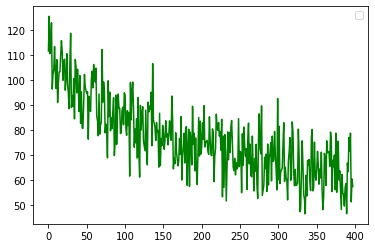

In [21]:
# print(loss_history)
err_n = get_model_error(model_new, testloader)
print_stats(model_new)
from utils import *
plot_graph(np.arange(len(loss_history)), loss_history)

## Batch Norm evaluation

In [35]:
model_bn = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Conv2d(16, 32, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Flatten(),
    nn.Linear(5408, 1152),
    nn.Tanh(),
    nn.BatchNorm1d(1152),
    nn.Linear(1152, 512),
    nn.Tanh(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 10)
)

In [36]:
loss_history_bn = []
writer_bn = SummaryWriter(log_dir='runs/bn_stats', flush_secs=10)

In [23]:
alpha = 0.1
optimizer_new = optim.SGD(model_bn.parameters(), lr=1e-4, momentum=0.9, weight_decay = 1/len(list(model_bn.parameters())))
# optimizer_old = optim.SGD(model_new.parameters(), lr=0.01, momentum=0.9, weight_decay = 1/len(list(model_new.parameters())))
optimizer_adam_new = optim.Adam(list(model_bn.parameters()), lr=3e-4)
# writer.add_graph(model_new, trainset)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_adam_new.zero_grad()

        # forward + backward + optimize
        outputs = model_bn(inputs)
        loss = criterion_p(outputs, labels, model_bn)
        loss.backward()
        optimizer_adam_new.step()
        if writer is not None:
            writer_bn.add_scalar("Loss/Train", loss.item())
            
        # print statistics
#         running_loss += loss.item()
        if i%10 == 9:
            loss_history_bn.append(loss.item())
        if i % 300 ==299:    # print every 2000 mini-batches
#             print('[%d, %5d] running_loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
#             running_loss = 0.0
    writer_bn.close()
    print('loss for epoch %d: %.3f' % (epoch+1, loss.item()))

[1,   300] loss: 80.156
[1,   600] loss: 86.769
loss for epoch 1: 22.074
[2,   300] loss: 75.361
[2,   600] loss: 75.502
loss for epoch 2: 27.813
[3,   300] loss: 64.358
[3,   600] loss: 67.213
loss for epoch 3: 19.942
[4,   300] loss: 73.064
[4,   600] loss: 58.656
loss for epoch 4: 18.490
[5,   300] loss: 58.896
[5,   600] loss: 45.755
loss for epoch 5: 29.817


In [24]:
model_wo_bn = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Conv2d(16, 32, 3),
    nn.FractionalMaxPool2d(2, output_ratio=(1/np.sqrt(2))),
    nn.Flatten(),
    nn.Linear(5408, 1152),
    nn.Tanh(),
    nn.Linear(1152, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 10)
)

In [25]:
loss_history_wo_bn = []
writer_wo_bn = SummaryWriter(log_dir='runs/wo_bn_stats', flush_secs=10)

In [ ]:
alpha = 0.1
optimizer_new = optim.SGD(model_wo_bn.parameters(), lr=1e-4, momentum=0.9, weight_decay = 1/len(list(model_wo_bn.parameters())))
# optimizer_old = optim.SGD(model_new.parameters(), lr=0.01, momentum=0.9, weight_decay = 1/len(list(model_new.parameters())))
optimizer_adam_new = optim.Adam(list(model_wo_bn.parameters()), lr=3e-4)
# writer.add_graph(model_new, trainset)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_adam_new.zero_grad()

        # forward + backward + optimize
        outputs = model_wo_bn(inputs)
        loss = criterion_p(outputs, labels, model_wo_bn)
        loss.backward()
        optimizer_adam_new.step()
        if writer_wo_bn is not None:
            writer_wo_bn.add_scalar("Loss/Train", loss.item())
            
        # print statistics
#         running_loss += loss.item()
        if i%10 == 9:
            loss_history_wo_bn.append(loss.item())
        if i % 300 ==299:    # print every 2000 mini-batches
#             print('[%d, %5d] running_loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
#             running_loss = 0.0
    print('loss for epoch %d: %.3f' % (epoch+1, loss.item()))
writer_wo_bn.close()